In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster')

ImportError: No module named 'seaborn'

## Models WIthout MSA Encoding

### Import, Split, and Standardize Data

In [2]:
df = pd.read_pickle('../data/merged/all_data_2006_to_2016.pkl')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928 entries, 0 to 927
Data columns (total 11 columns):
year                                                                           928 non-null int64
MSA                                                                            928 non-null object
now_married_except_separated                                                   928 non-null float64
less_than_high_school_diploma                                                  928 non-null float64
unmarried_portion_of_women_15_to_50_years_who_had_a_birth_in_past_12_months    928 non-null float64
households_with_food_stamp_snap_benefits                                       928 non-null float64
percentage_married_couple_family                                               928 non-null float64
percentage_female_householder_no_husband_present_family                        928 non-null float64
poverty_all_people                                                             928 non-null float6

In [4]:
# drop MSA names
df = df.drop('MSA', axis=1)

In [5]:
# separate labels and features

label_col = 'murder_per_100_k'

x = df.drop([label_col], axis=1)
y = df[label_col]

print('Sizes match: {}'.format(len(x)==len(y)))

Sizes match: True


In [6]:
# train test split

from sklearn.model_selection import train_test_split

x_train_s, x_test_s, y_train, y_test = train_test_split(x,y, test_size=0.3)

print('Len x_train: {}'.format(len(x_train_s)))
print('Len x_test: {}'.format(len(x_test_s)))
print('Len y_train: {}'.format(len(y_train)))
print('Len x_test: {}'.format(len(y_test)))

Len x_train: 649
Len x_test: 279
Len y_train: 649
Len x_test: 279


In [7]:
# standardize data

from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler().fit(x_train_s)

x_train = standardizer.transform(x_train_s)
x_test = standardizer.transform(x_test_s)

### Simple Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, BayesianRidge, HuberRegressor
from sklearn.model_selection import GridSearchCV

In [9]:
# instantiate and fit models

def make_models(x_train, y_train):
    md = dict()

    md['linear'] = LinearRegression().fit(x_train, y_train)
    md['ridge'] = RidgeCV(cv=15).fit(x_train, y_train)
    md['lasso'] = LassoCV(cv=15).fit(x_train, y_train)
    md['bayes'] = BayesianRidge(tol=0.0001).fit(x_train, y_train)
    md['huber'] = GridSearchCV(HuberRegressor(),{'epsilon': [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7]}).fit(x_train, y_train).best_estimator_
    
    return md

In [10]:
# score models

def score_model(model):

    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)

    return np.array([train_score, test_score])

In [15]:
def results_df(model):

    # get train and test scores
    scores_df = pd.DataFrame(score_model(model)).transpose()
    scores_df.columns = ['Train R2','Test R2']

    # get coefficient matrix
    coeffs_df = pd.DataFrame(model.coef_).transpose()
    coeffs_df.columns = x.columns

    # join dataframes
    return pd.concat([scores_df, coeffs_df], axis=1)

In [12]:
from sklearn.utils import resample

In [13]:
def run_experiment(n_iters):
    
    sample_results = dict()
    
    for n in range(n_iters):
        # get new sample
        xb, yb = resample(x_train, y_train)

        # make and fit models
        model_dict = make_models(xb, yb)

        # get sample of results for each model
        for key in model_dict:
            
            # initialize empty dictionary
            if key not in sample_results:
                sample_results[key] = []
                        
            # get model results
            sample_results[key].append(results_df(model_dict[key]))
            
    # concatenate results dfs into single df
    for key in sample_results:
        sample_results[key] = pd.concat(sample_results[key])
        
    return sample_results

In [74]:
exp = run_experiment(200)

In [75]:
coef_dict = dict()

# iterate over all models
for key in exp:
    
    # iterate over results of this model
    for c in exp[key].columns:
        
        # initialize dict for result names
        if c not in coef_dict:
            coef_dict[c] = dict()
    
        # add this coeff to the dict
        coef_dict[c][key] = exp[key][c]

# convert dict of dicts into dict of dataframes
coef_dfs = {key: pd.DataFrame(coef_dict[key]) for key in coef_dict}

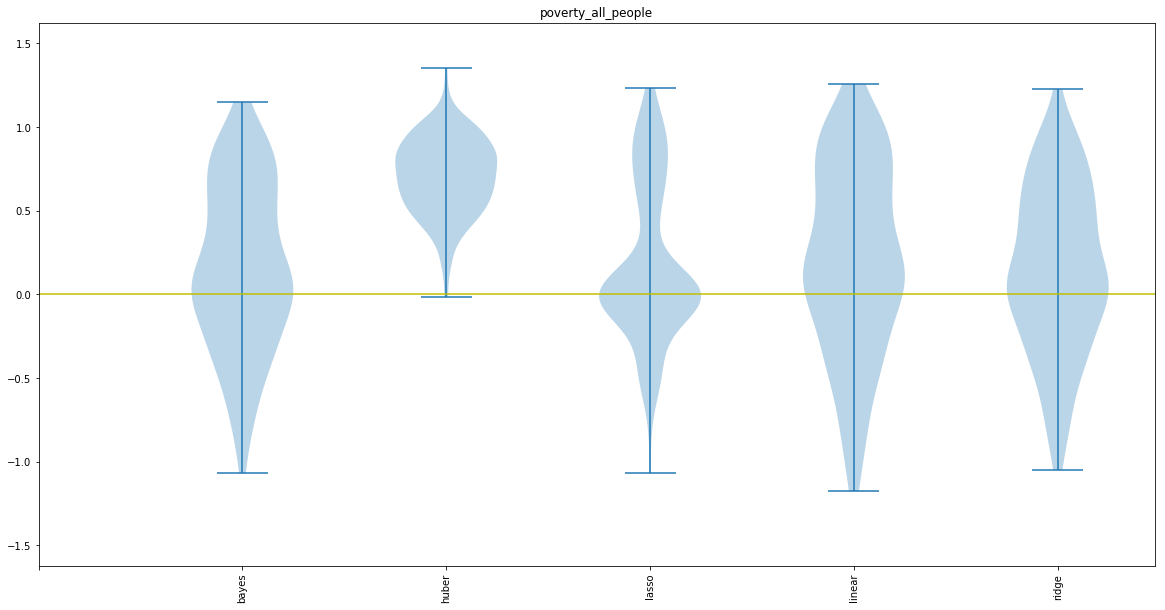

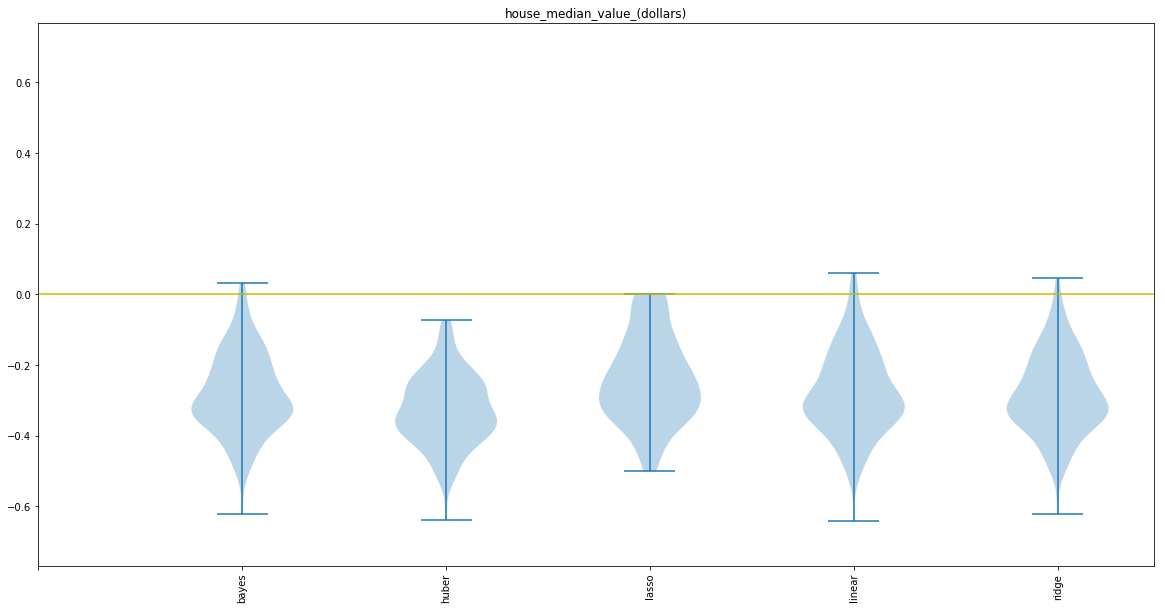

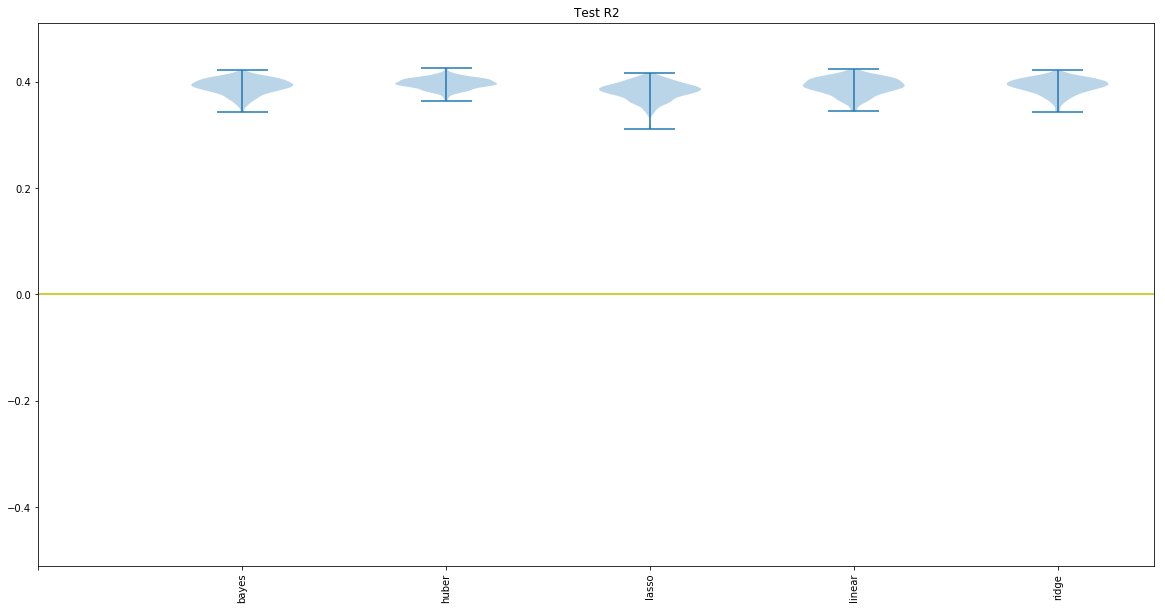

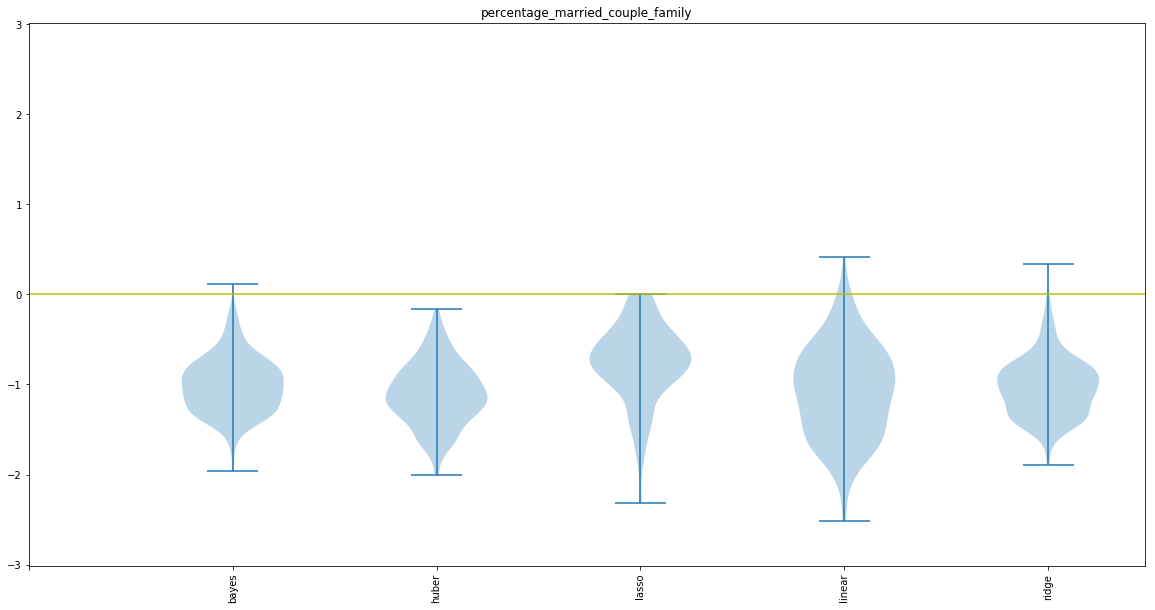

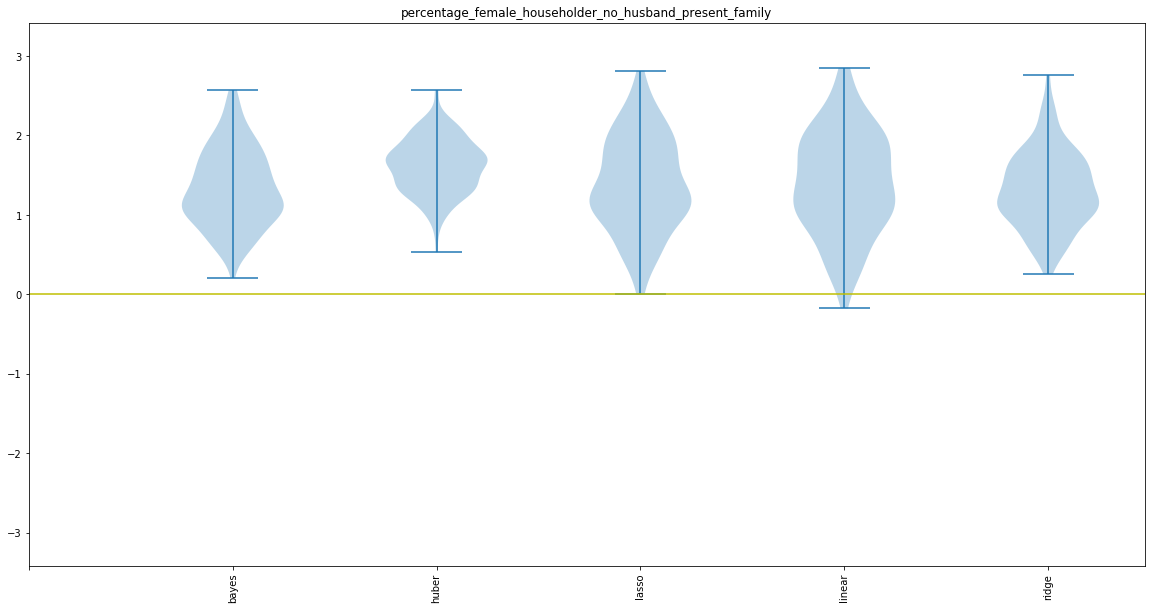

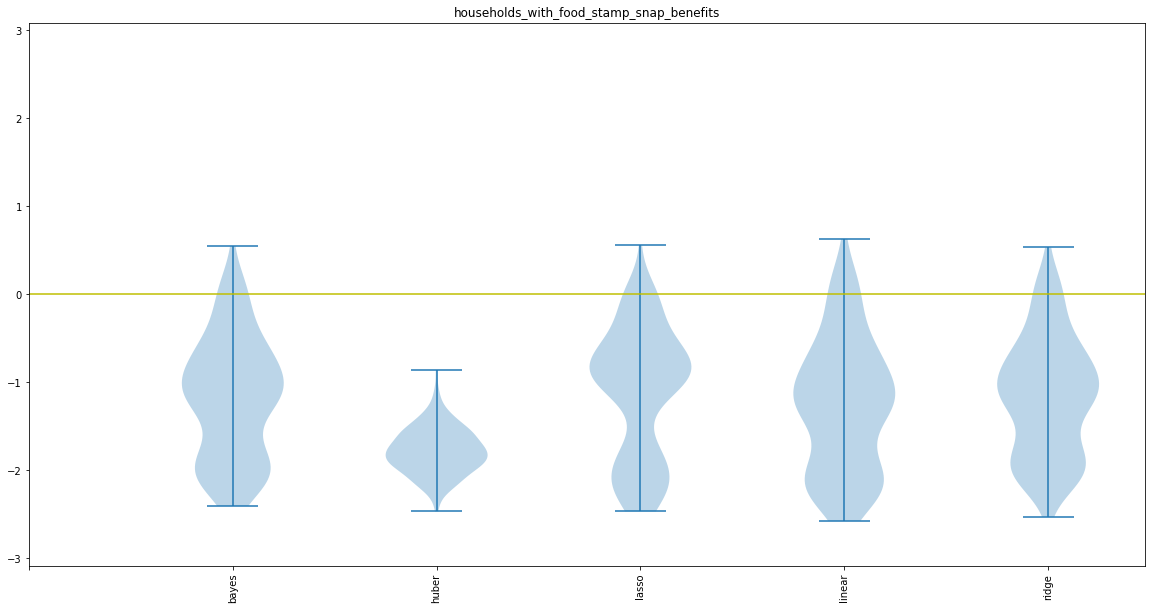

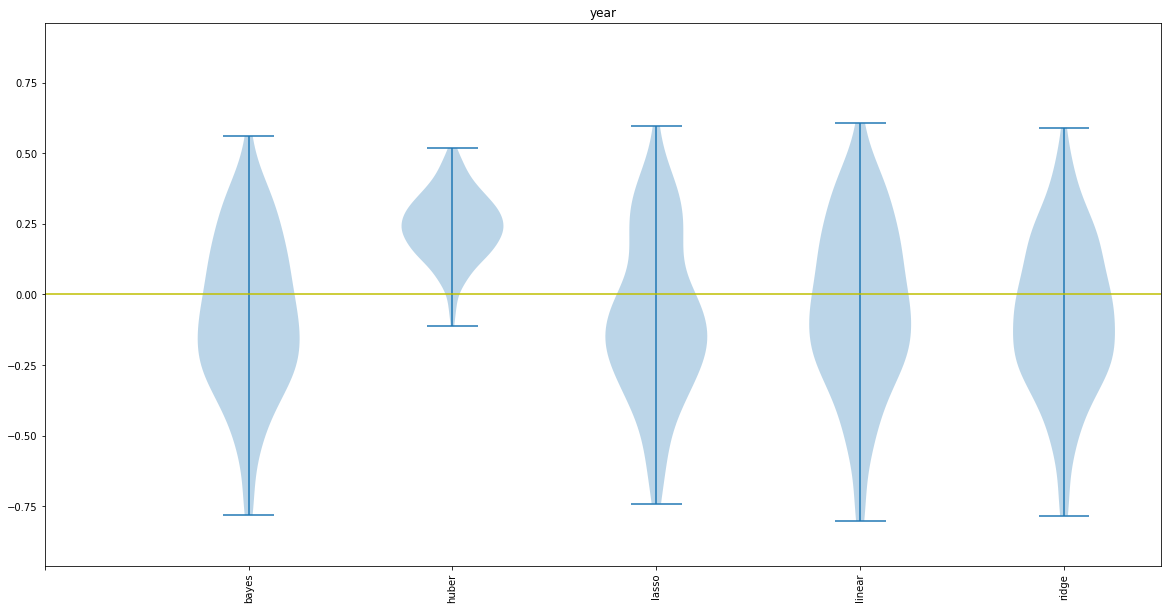

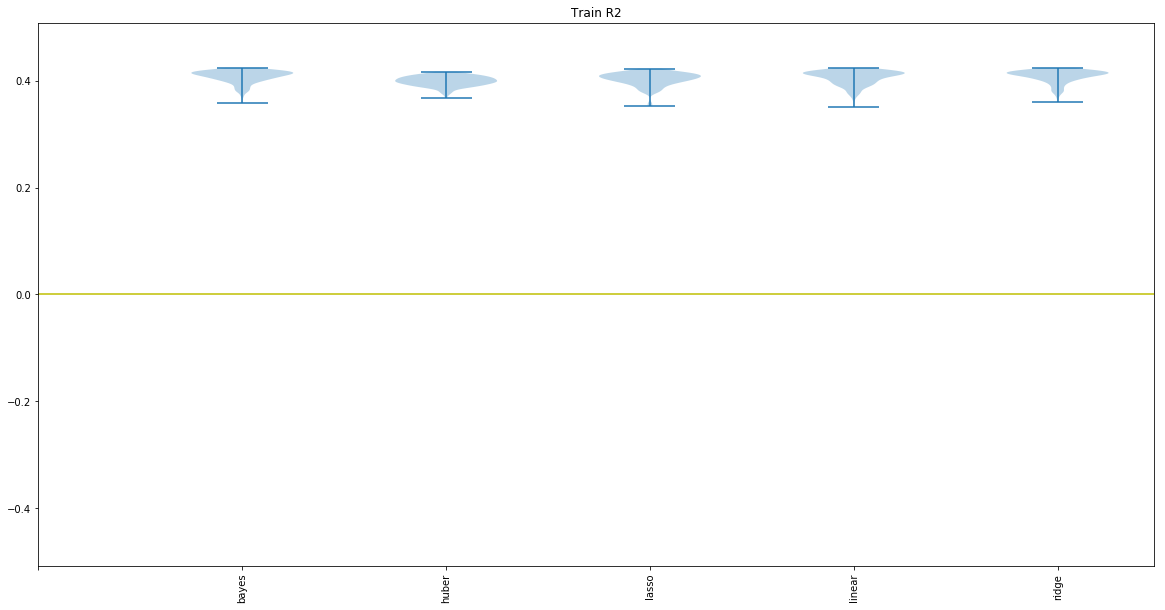

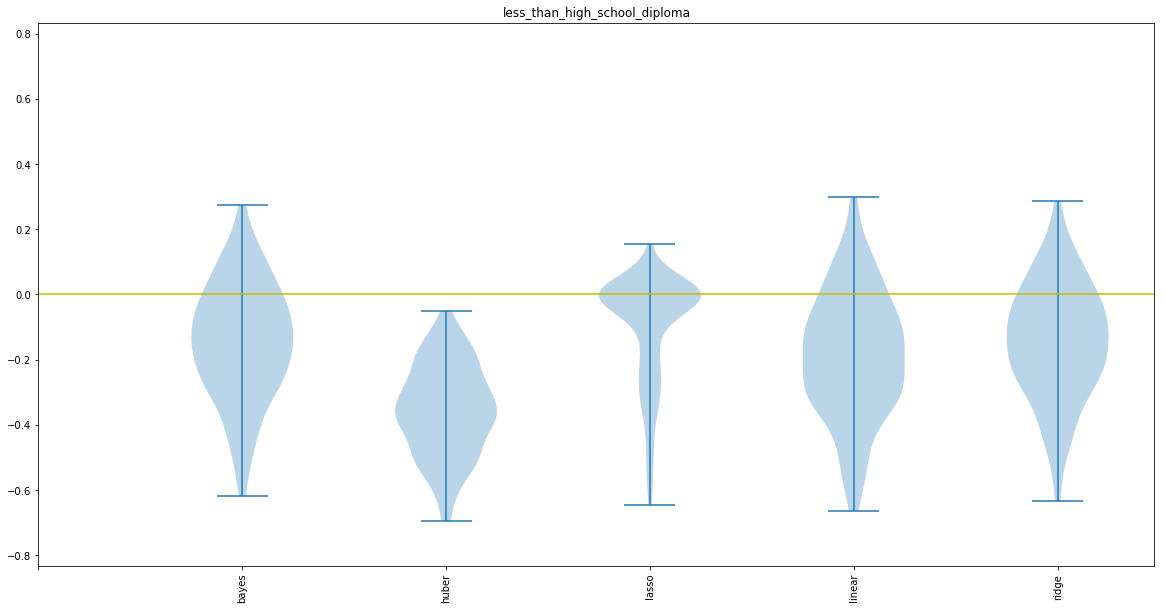

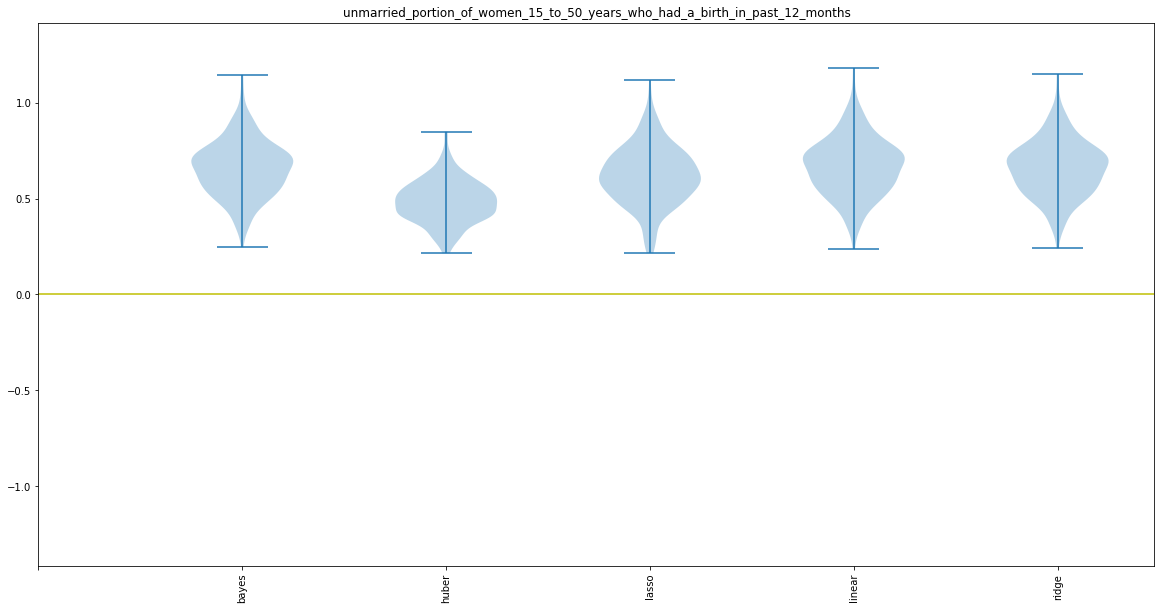

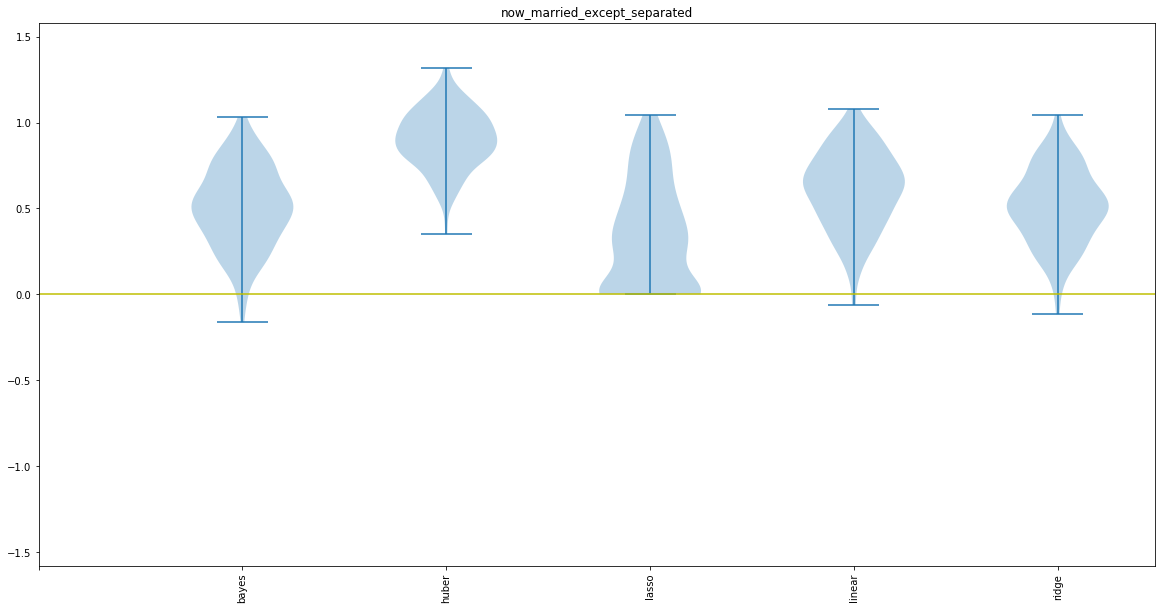

In [76]:
# violin plots of the experimental results

for key in coef_dfs:
    
    plt.figure(figsize=(20,10))
    plt.violinplot(coef_dfs[key].transpose())
    
    # center everything on 0 but allow scale adjustment
    lim = np.abs(coef_dfs[key].values).max()*1.2
    plt.ylim((-lim,lim))
    
    x_labels = list(coef_dfs[key].columns)
    plt.xticks(range(len(x_labels)+1), ['']+x_labels, rotation='vertical')
    plt.axhline(c='y')
    plt.title(key);